In [1]:
import numpy as np
import pandas as pd
import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# THIS REMOVES ARTICLES WRITTEN ON NON-BUSINESS DAYS

hist_df = pd.read_csv('data/AAPL_2024-06-16.csv')
sent_df = pd.read_csv('data/AAPL_sent.csv')
df = pd.merge(hist_df, sent_df, left_on='timestamp', right_on='date', how='left')
df = df[['timestamp','open','high','low','close','volume','compound']]
df.rename(columns={'compound': 'sentiment'}, inplace=True)
df

,timestamp,open,high,low,close,volume,sentiment
0,1999-11-01,80.00,80.69,77.37,77.62,2487300,NaN
1,1999-11-02,78.00,81.69,77.31,80.25,3564600,NaN
2,1999-11-03,81.62,83.25,81.00,81.50,2932700,NaN
3,1999-11-04,82.06,85.37,80.62,83.62,3384700,NaN
4,1999-11-05,84.62,88.37,84.00,88.31,3721500,NaN
...,...,...,...,...,...,...,...
6190,2024-06-10,196.90,197.30,192.15,193.12,97262077,-0.045220
6191,2024-06-11,193.65,207.16,193.63,207.15,172373296,0.085237
6192,2024-06-12,207.37,220.20,206.90,213.07,198134293,0.131361
6193,2024-06-13,214.74,216.75,211.60,214.24,97862729,0.008962


In [3]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [4]:
def split_data(data, training_split, features):
  split_row = int(data.shape[0]*training_split)
  training_set = data[features].iloc[:split_row].values
  testing_set = data[features].iloc[split_row:].values
  return training_set, testing_set


def get_x_y(dataset, window_size, label_feature, feature_count):
  X, y = [], []
  for i in range(window_size, len(dataset)):
    X.append(dataset[i-window_size:i])
    y.append(dataset[i, label_feature])

  X, y = np.array(X), np.array(y)
  X = np.reshape(X, (X.shape[0], window_size, feature_count))
  return X, y

In [5]:
# Replace NaNs with a temporary placeholder for scaling
placeholder_value = -2
df['sentiment'].fillna(placeholder_value, inplace=True)

# Split data into training and testing
training_set, testing_set = split_data(df, 0.8, ['open', 'high', 'low', 'close', 'volume', 'sentiment'])
print("training_set: ", training_set.shape)
print("testing_set: ", testing_set.shape)

training_set:  (4956, 6)
testing_set:  (1239, 6)


C:\Users\blkeu\AppData\Local\Temp\ipykernel_24028\3117906116.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].fillna(placeholder_value, inplace=True)


In [6]:
# Example data preparation
scaler = MinMaxScaler()

training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)

In [7]:
X_train, y_train = get_x_y(training_set, 14, 4, 6)
val_split_row = int(X_train.shape[0]*0.8) # 20% will be used for validation
X_train, X_val = X_train[:val_split_row], X_train[val_split_row:]
y_train, y_val = y_train[:val_split_row], y_train[val_split_row:]
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)

X_train:  (3953, 14, 6)
y_train:  (3953,)
X_val:  (989, 14, 6)
y_val:  (989,)


In [8]:
X_train

array([[[0.09719764, 0.09756027, 0.09412535, 0.09361665, 0.00945048,
         0.        ],
        [0.09429666, 0.09900561, 0.094038  , 0.09743389, 0.01515476,
         0.        ],
        [0.09954745, 0.10126033, 0.09941035, 0.09924816, 0.01180887,
         0.        ],
        ...,
        [0.11170259, 0.1135457 , 0.11032977, 0.11331243, 0.0073362 ,
         0.        ],
        [0.11270343, 0.11788171, 0.11251365, 0.1119481 , 0.01351597,
         0.        ],
        [0.11324011, 0.11263514, 0.11024241, 0.1110337 , 0.01352603,
         0.        ]],

       [[0.09429666, 0.09900561, 0.094038  , 0.09743389, 0.01515476,
         0.        ],
        [0.09954745, 0.10126033, 0.09941035, 0.09924816, 0.01180887,
         0.        ],
        [0.10018566, 0.10432445, 0.0988571 , 0.10232518, 0.0142022 ,
         0.        ],
        ...,
        [0.11270343, 0.11788171, 0.11251365, 0.1119481 , 0.01351597,
         0.        ],
        [0.11324011, 0.11263514, 0.11024241, 0.1110337 , 0.013

In [9]:
# seq_length = 60  # Example sequence length
# sequences = create_sequences(data, seq_length)

In [10]:
# # Creating mask for missing sentiment values
# sentiment_column_index = 5
# mask = np.isnan(sequences[:, :, sentiment_column_index])

# # Replacing NaNs with a placeholder (e.g., -2) that will be masked out
# sequences[:, :, sentiment_column_index] = np.nan_to_num(sequences[:, :, sentiment_column_index], nan=-2)

# X = sequences[:, :-1, :]
# y = sequences[:, -1, 3]  # Example: predicting the 'close' price

In [11]:
# split = int(0.8 * len(X))
# X_train, X_test = X[:split], X[split:]
# y_train, y_test = y[:split], y[split:]
# mask_train, mask_test = mask[:split, :-1], mask[split:, :-1]

In [12]:
# placeholder_value = -2
# X_train[:, :, 5][np.isnan(X_train[:, :, 5])] = placeholder_value
# X_test[:, :, 5][np.isnan(X_test[:, :, 5])] = placeholder_value

# # Create mask arrays: True where sentiment is placeholder_value, False otherwise
# mask_train = (X_train[:, :, 5] == placeholder_value)
# mask_test = (X_test[:, :, 5] == placeholder_value)

In [13]:
# # Custom loss function to ignore masked values
# def custom_loss(y_true, y_pred):
#     mask = tf.cast(tf.not_equal(y_true, -2), dtype=tf.float32)
#     loss = tf.reduce_sum(mask * tf.square(y_true - y_pred)) / tf.reduce_sum(mask)
#     return loss

def build_model(window_size, feature_count):
    d = 0.1
    model = Sequential()
    model.add(Masking(mask_value=placeholder_value, input_shape=(window_size, feature_count)))
    model.add(LSTM(128, input_shape=(window_size, feature_count), return_sequences=True))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    # model.compile(optimizer='adam', loss=custom_loss)
    return model

In [14]:
window_size = 60  # Example window size
feature_count = 6  # Number of features (e.g., open, high, low, close, volume, sentiment)
model = build_model(window_size, feature_count)
model.summary()

c:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\blkeu\anaconda3\envs\CS172B311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,273 (352.63 KB)

 Trainable params: 90,273 (352.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0090 - mae: 0.0667 - val_loss: 0.0146 - val_mae: 0.0948
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - mae: 0.0370 - val_loss: 0.0069 - val_mae: 0.0552
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - mae: 0.0320 - val_loss: 0.0081 - val_mae: 0.0528
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - mae: 0.0330 - val_loss: 0.0056 - val_mae: 0.0474
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0029 - mae: 0.0318 - val_loss: 0.0071 - val_mae: 0.0562
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0021 - mae: 0.0285 - val_loss: 0.0066 - val_mae: 0.0448
Epoch 7/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - mae: 0.0301 - val_loss: 0.0064 - val_mae: 0.0470
Epoch 8/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - mae: 0.0283 - val_loss: 0.0066 - val_mae: 0.0603
Epoch 9/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - mae:

In [16]:
# Scale test set
scaler = MinMaxScaler()
testing_set = scaler.fit_transform(testing_set)

# Get X and y from testing set
X_test, y_test = get_x_y(testing_set, 14, 4, 6)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

X_test:  (1225, 14, 6)
y_test:  (1225,)
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0453
Test Loss: [0.005045434460043907, 0.046507567167282104]


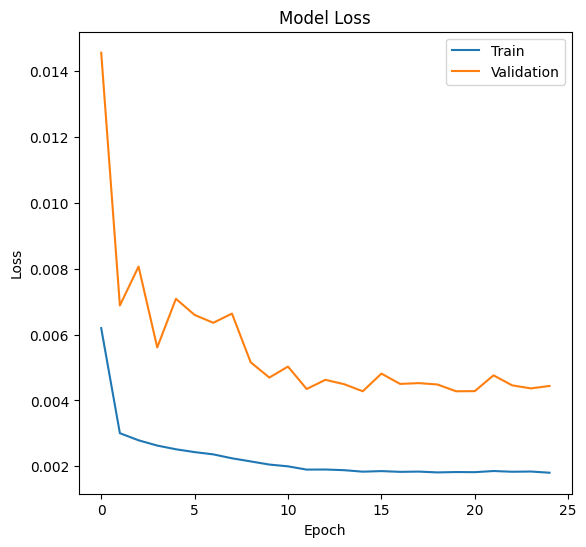

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


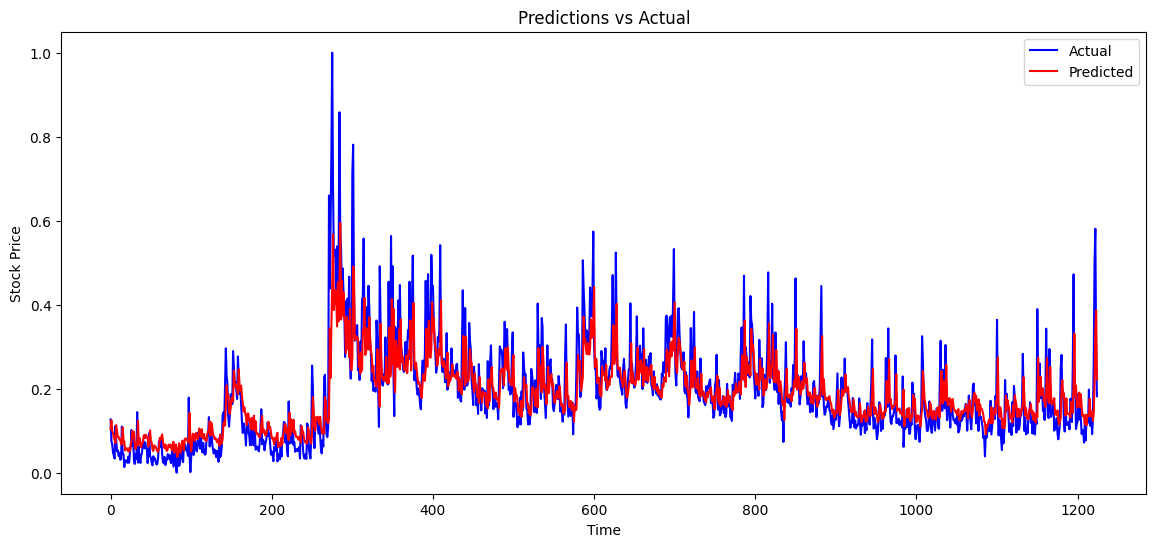

In [18]:
# Generate predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual results
plt.figure(figsize=(14, 6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [19]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0453
test loss, test acc: [0.005045434460043907, 0.046507567167282104]
